###Unzipping dataset

In [ ]:
print("Unzipping...")
!unzip -q drive/MyDrive/projectdatanew.zip
print("Done!!")

Unzipping...
Done!!


### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import math

In [ ]:
#Import Keras modules
import keras
from keras import backend as K
from keras.models import Sequential,Model
from keras.layers import BatchNormalization,Dense, Dropout,  Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D, MaxPool2D, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.regularizers import L2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.callbacks import EarlyStopping, TensorBoard,ModelCheckpoint,  LearningRateScheduler

In [ ]:
#Import sklearn libraries
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
label_to_class = {
    'B-1':0,
    'B-2':1,
    'B-52':2,
    'Boeing':3,
    'C-130':4,
    'C-135':5,
    'C-17':6,
    'C-5':7,
    'E-3':8,
    'F-22':9,
    'KC-10':10,
    'type-12(C-21)':11,
    'type-13(U-2)':12,
    'type-15(A-10)':13,
    'type-16(A-26)':14,
    'type-17(P-63)':15,
    'type-18(F-16)':16,
    'type-19(T-6)':17,
    'type-20(B-29)':18,
    'type-21(t-43)':19,
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

In [ ]:
class_to_label

{0: 'B-1',
 1: 'B-2',
 2: 'B-52',
 3: 'Boeing',
 4: 'C-130',
 5: 'C-135',
 6: 'C-17',
 7: 'C-5',
 8: 'E-3',
 9: 'F-22',
 10: 'KC-10',
 11: 'type-12(C-21)',
 12: 'type-13(U-2)',
 13: 'type-15(A-10)',
 14: 'type-16(A-26)',
 15: 'type-17(P-63)',
 16: 'type-18(F-16)',
 17: 'type-19(T-6)',
 18: 'type-20(B-29)',
 19: 'type-21(t-43)'}

Creation of **dataframe with class names and labels**

### Resizing images

In [ ]:
def get_min_resolution(dir_name='/content/airplane-dataset-trans', label_to_class=label_to_class):
    #Images = []
    #Classes = []
    img_size = []
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
    
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            im = load_img('/'.join([dir_name, label_name, img_name]))
            img_size.append((label_name+ '/' + img_name, im.size))
            
    return img_size

In [ ]:
img_size_list = get_min_resolution()

#Getting Minimum and maximum resolution of images
min([x[1] for x in img_size_list]), max([x[1] for x in img_size_list])

((80, 80), (588, 447))

## **Preprocessing Steps:**

## 1. Resizing

In [ ]:
#Target sizes of (80,80) are used
W= 80 
H = 80

def change_images(dir_name='airplane-dataset-trans', label_to_class=label_to_class):
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.int)
    
    return Images, Classes

In [ ]:
Images, Classes = change_images()

Images.shape, Classes.shape

((9385, 80, 80, 3), (9385,))

Getting images/labels

### Number of images in each class

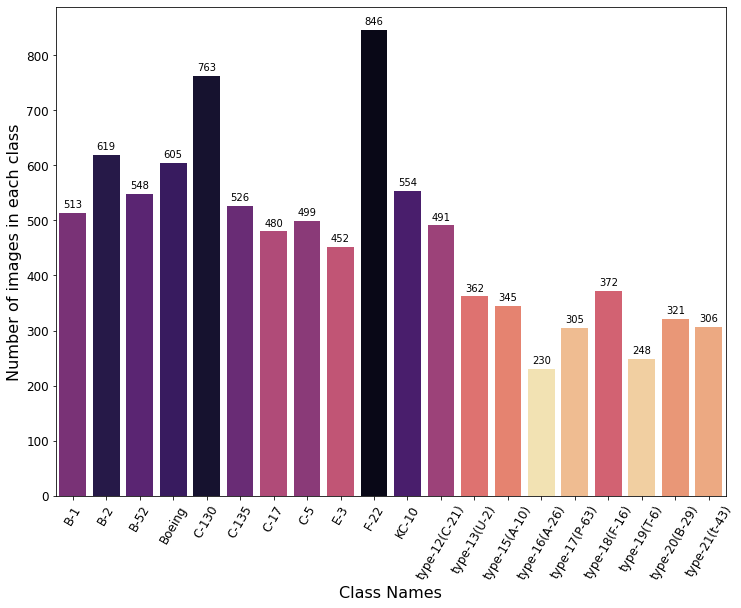

In [ ]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(12, 9))
pal = sns.color_palette("magma", len(class_names_count_df))
rank = class_names_count_df["ImgCount"].argsort().argsort() 

#Barplot with count
plots = sns.barplot(x="className", y="ImgCount",data=class_names_count_df, palette=np.array(pal[::-1])[rank])
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.ImgCount+10, s=row.ImgCount, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=16)
  
# Setting the label for y-axis
plt.ylabel("Number of images in each class", size=16)
  
# Setting the title for the graph
  
# Fianlly showing the plot
plt.show()

- F-22, C-130, B-2, Boeing classes have more images than the rest, this can help in better prediction of these classes.
- type-16 (A-26), type-19(T-6) classes have lower number of images so may require augmentation or addition of more data to predict well

B-1


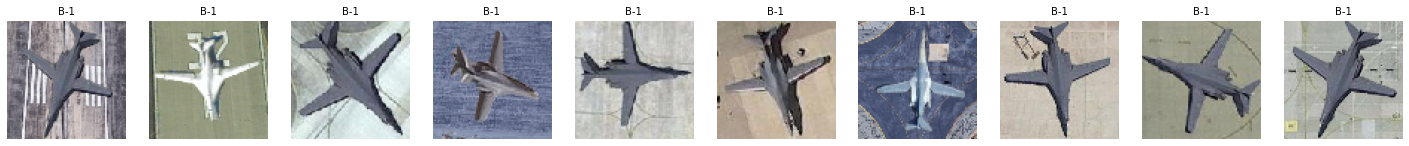

B-2


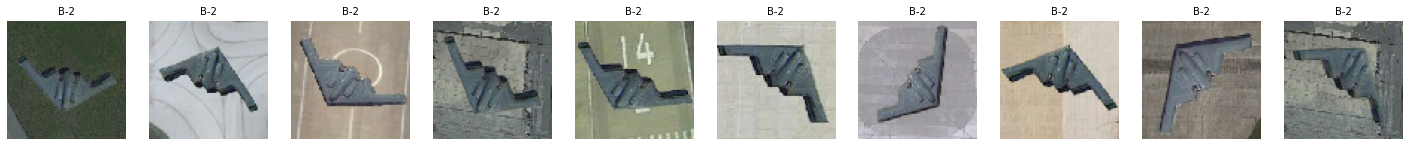

B-52


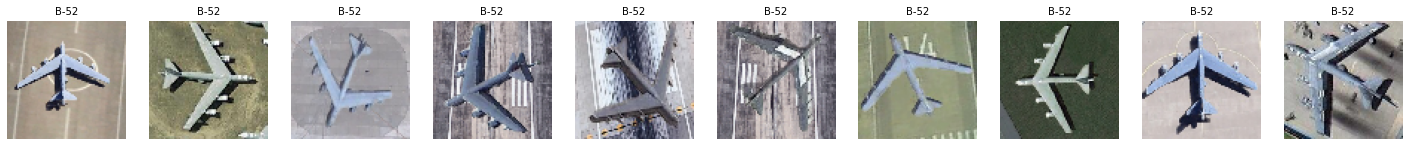

Boeing


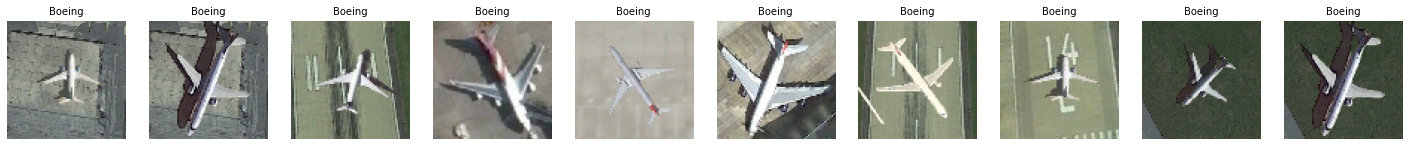

C-130


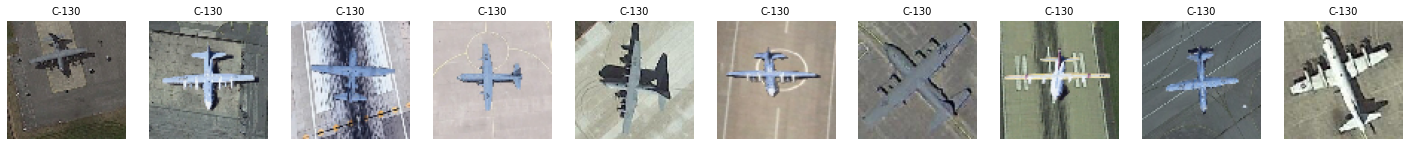

C-135


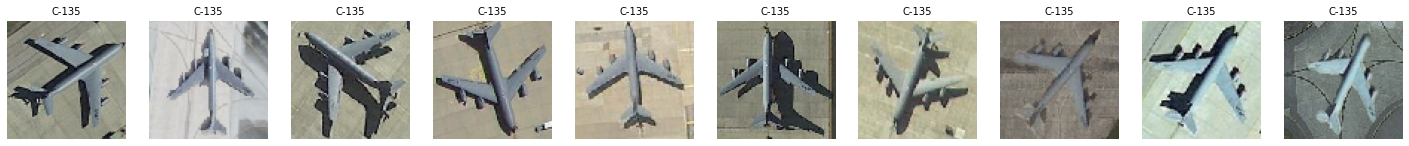

C-17


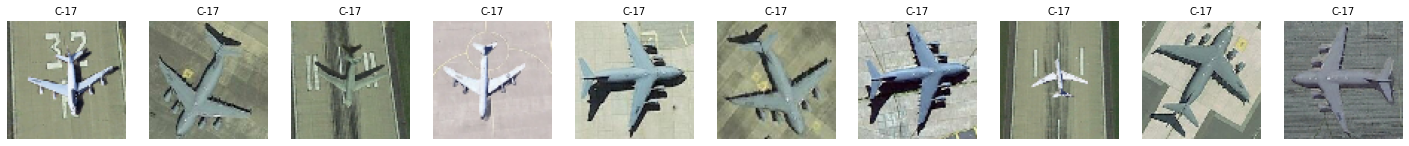

C-5


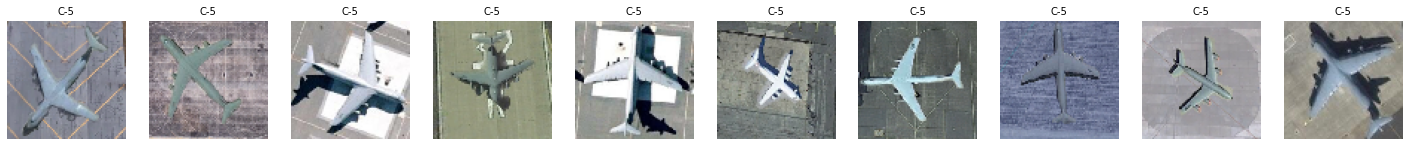

E-3


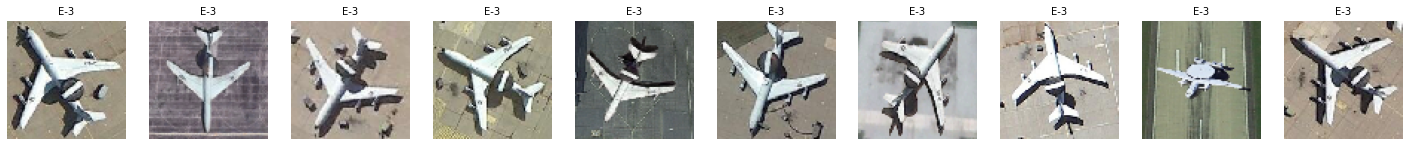

F-22


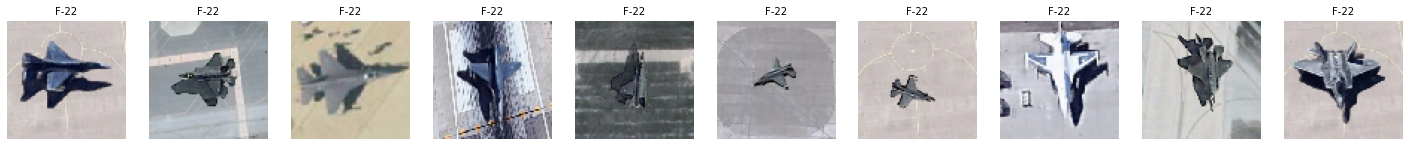

KC-10


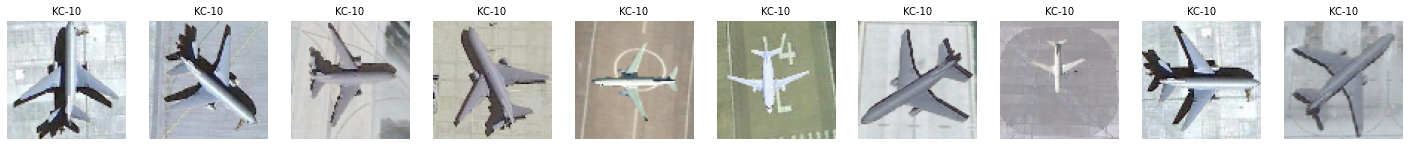

type-12(C-21)


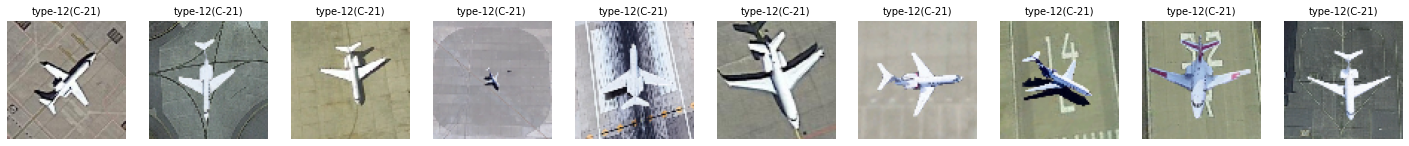

type-13(U-2)


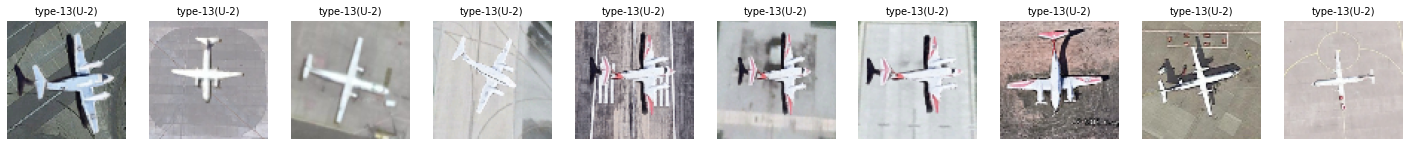

type-15(A-10)


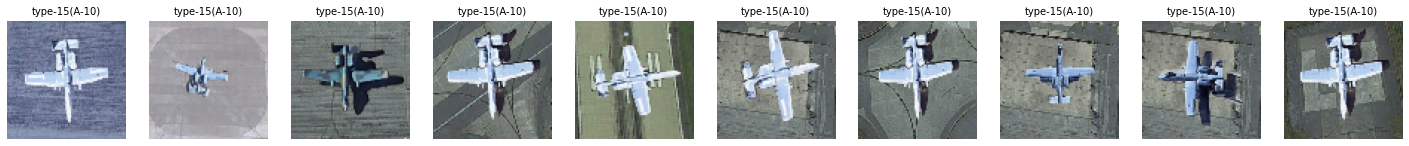

type-16(A-26)


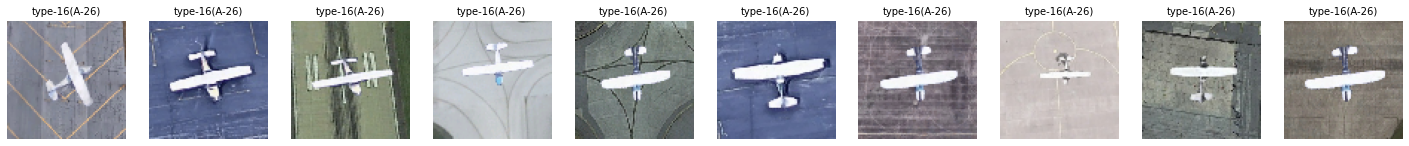

type-17(P-63)


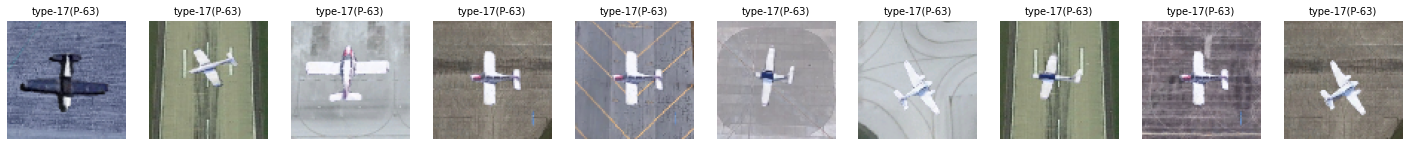

type-18(F-16)


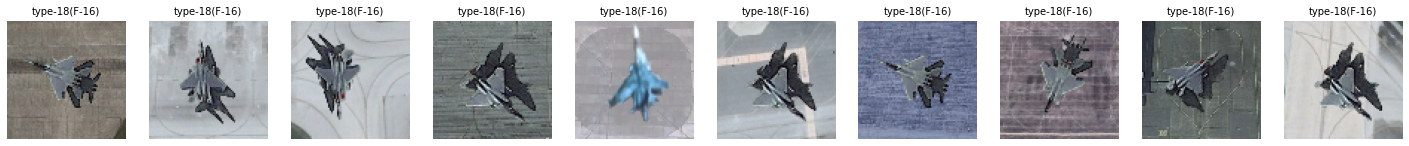

type-19(T-6)


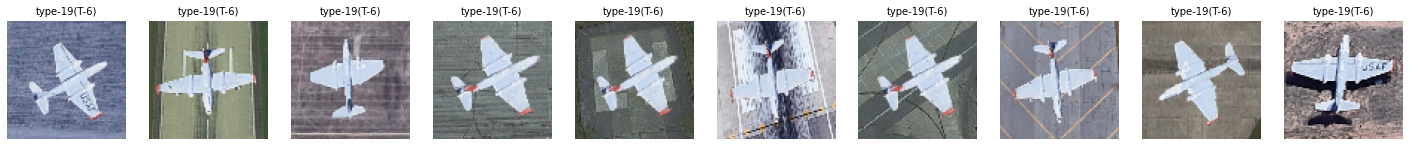

type-20(B-29)


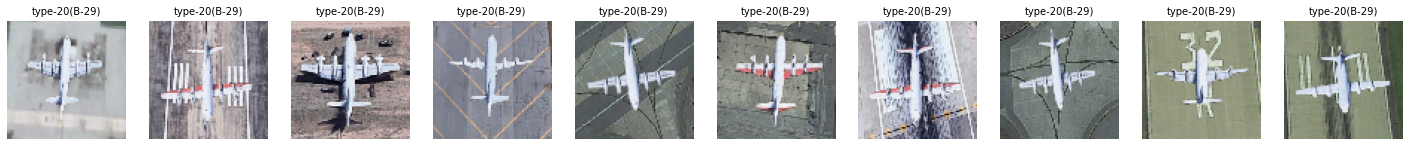

type-21(t-43)


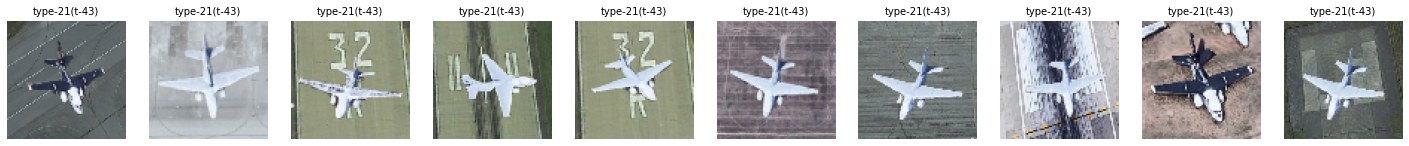

In [ ]:
n_total_images = Images.shape[0]
for target_cls in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label)

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label, fontsize =10)

    plt.show()

## Split dataset into train, validation and test

In [ ]:
#Import sklearn libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
#splitting dataset into train,test and validation
x_train, x_val_test, y_train, y_val_test = train_test_split(Images, Classes, train_size=0.8, test_size=0.2, stratify=Classes, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, train_size=0.8, test_size=0.2, stratify=y_val_test, random_state=42)

In [ ]:
## transforming categorical to one-hot
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape ,y_val.shape, y_test.shape #(7508, 20)

((7508, 20), (1501, 20), (376, 20))

## 2. Normalising input images


In [ ]:
x_train /=255
x_val /=255
x_test /=255

## Model building 

## First Model











In [ ]:

#Basic CNN model
model = Sequential()

# Block 1
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(80, 80, 3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 3
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 4
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.0001)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Dense
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Softmax activation function
model.add(Dense(20, activation='softmax'))

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

## Model Training


##Hyperparamters used:
**learning rate** (lr = 0.0001)
<br>**batch size**  (batch size =16)
<br>**number of epochs** (epochs = 25)

In [ ]:
# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * math.exp(-0.1)

In [ ]:
print("Fit model on training data")
history = model.fit(x_train, y_train, epochs=25, batch_size=16, callbacks=my_callbacks, validation_data=(x_val, y_val))

Fit model on training data
Epoch 1/25
470/470 [==============================] - 18s 14ms/step - loss: 4.0267 - accuracy: 0.1006 - val_loss: 3.8468 - val_accuracy: 0.1339 - lr: 1.0000e-04
Epoch 2/25
470/470 [==============================] - 5s 10ms/step - loss: 3.6492 - accuracy: 0.1633 - val_loss: 3.3424 - val_accuracy: 0.2845 - lr: 1.0000e-04
Epoch 3/25
470/470 [==============================] - 5s 10ms/step - loss: 3.3565 - accuracy: 0.2288 - val_loss: 3.0125 - val_accuracy: 0.3738 - lr: 1.0000e-04
Epoch 4/25
470/470 [==============================] - 4s 8ms/step - loss: 3.1004 - accuracy: 0.2929 - val_loss: 2.7416 - val_accuracy: 0.4763 - lr: 1.0000e-04
Epoch 5/25
470/470 [==============================] - 5s 10ms/step - loss: 2.8662 - accuracy: 0.3595 - val_loss: 2.5209 - val_accuracy: 0.5510 - lr: 1.0000e-04
Epoch 6/25
470/470 [==============================] - 5s 10ms/step - loss: 2.6471 - accuracy: 0.4197 - val_loss: 2.2893 - val_accuracy: 0.6196 - lr: 1.0000e-04
Epoch 7/25
47

### Plotting Model metrics

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

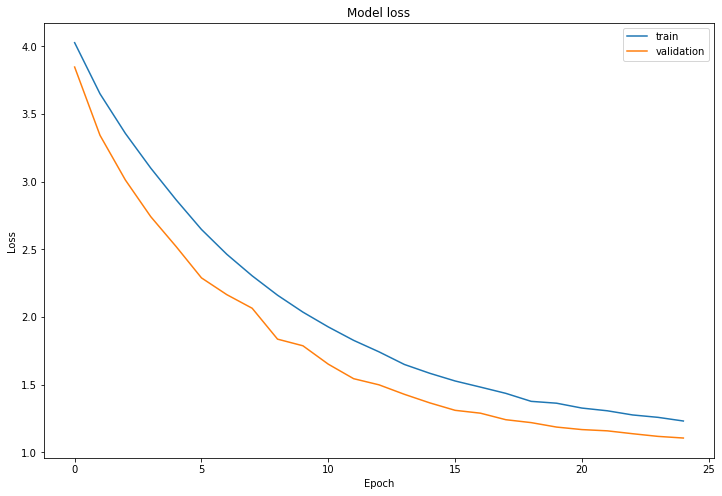

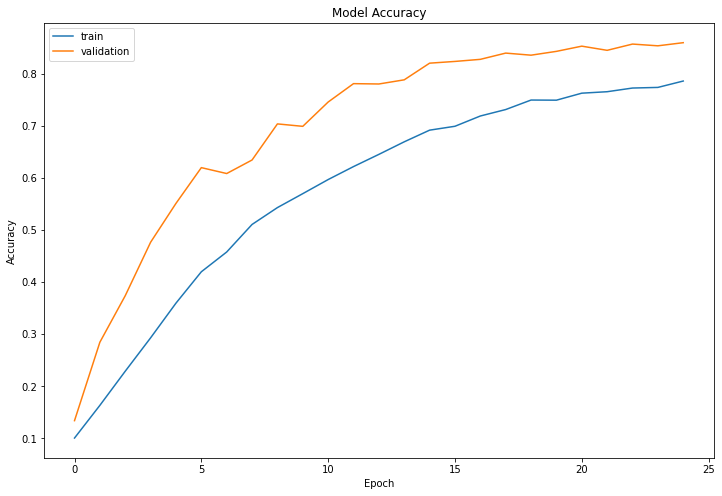

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

### Save the model as .h5 file

In [ ]:
#Save model
model.save('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
print("model saved!!!")

model saved!!!


### Load the saved .h5 model file

In [ ]:
#Load model
print("Model Loading...")
model = load_model('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
model.summary()

Model Loading...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                       

## Evaluating model performance on test data

In [ ]:
# Checking the model efficiency on the test data`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
24/24 [==============================] - 1s 15ms/step - loss: 1.0733 - accuracy: 0.8644
test loss, test acc: [1.0733109712600708, 0.8643617033958435]


## Misclassified Images

In [ ]:
class_pred = []
pred_label = []
act_label= []
misclassified_img = []
for i in range(predictions.shape[0]):
  class_pred.append(predictions[i].argmax())
  pred_label.append(class_to_label[class_pred[i]])
  act_label.append(class_to_label[y_test[i].argmax()])
  if pred_label[i] != act_label[i]:
    misclassified_img.append(i)

In [ ]:
print("Number of misclassified images",len(misclassified_img))

Number of misclassified images 86


ValueError: ignored

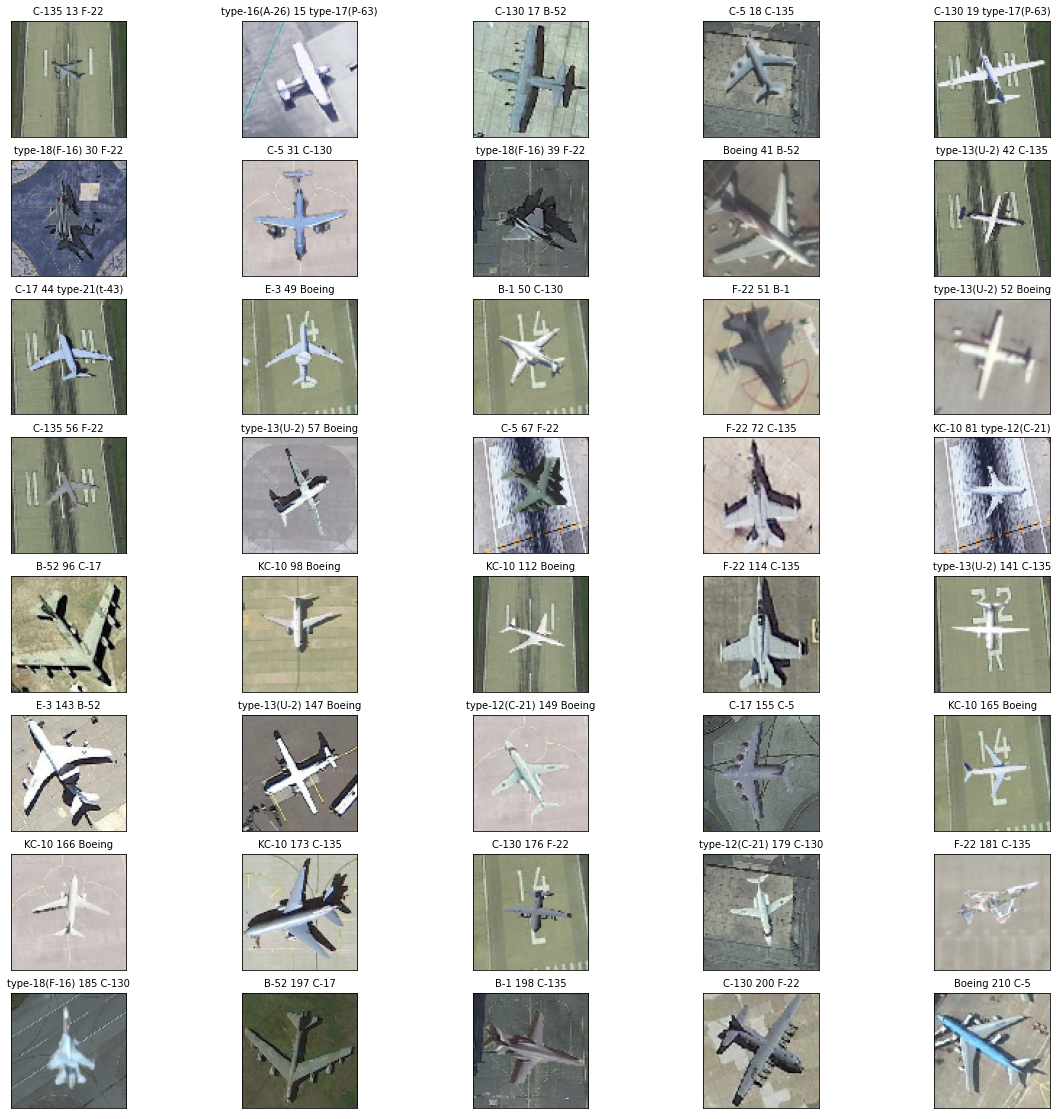

In [ ]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(misclassified_img)):
  ax = fig.add_subplot(8, 5, i+1,xticks=[], yticks=[])
  image = x_test[misclassified_img[i]]
  label_true = act_label[misclassified_img[i]]
  label_guess = pred_label[misclassified_img[i]]
  ax.imshow(image)
  ax.set_title("{} {:0.0f} {}".format(label_true, misclassified_img[i], label_guess), fontsize=10)


#There are many mis-classified images

## Confusion Matrix


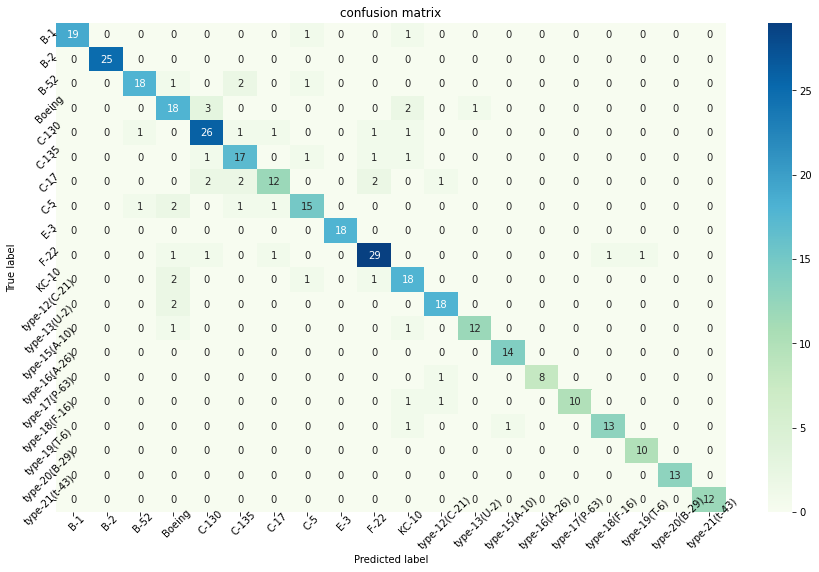

In [ ]:
## plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis =1), class_pred)

fig, ax = plt.subplots(figsize=(15, 9))

sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')

params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
#Class wise accuracy
matrix = confusion_matrix(np.argmax(y_test, axis =1), class_pred)
class_acc = ((matrix.diagonal()/matrix.sum(axis=1)) *100)
print((matrix.diagonal()/matrix.sum(axis=1)) *100)

[ 90.47619048 100.          81.81818182  75.          83.87096774
  80.95238095  63.15789474  75.         100.          85.29411765
  81.81818182  90.          85.71428571 100.          88.88888889
  83.33333333  86.66666667 100.         100.         100.        ]


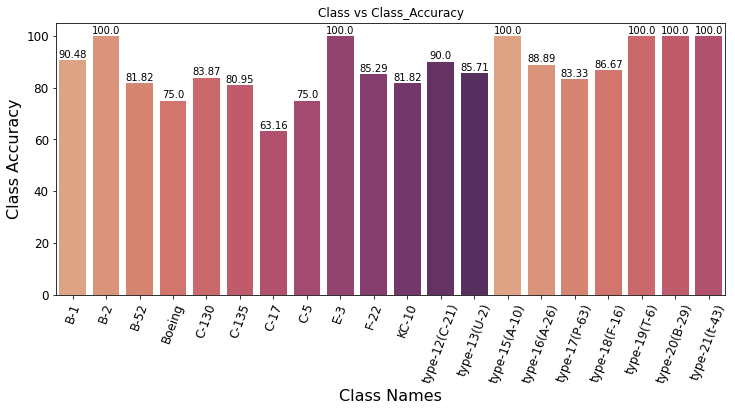

In [ ]:
#Seaborn Barplot and it's arguments
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
pal = sns.color_palette("flare", n_colors=len(set(class_names_count_df["Class_Accuracy"])))

#Barplot with count
plots = sns.barplot(x="className", y="Class_Accuracy",data=class_names_count_df, palette=pal)
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.Class_Accuracy+1, s=row.Class_Accuracy, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=16)
  
# Setting the label for y-axis
plt.ylabel("Class Accuracy", size=16)
  
# Setting the title for the graph
plt.title("Class vs Class_Accuracy")
  
# Fianlly showing the plot
plt.show()

## Second model 


In [ ]:

# Initialise model
model = Sequential()

# Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(80, 80, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 3
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 4
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(20, activation='softmax'))

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00004),
    metrics=['accuracy']
)

## Final proposed model 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from keras.applications import vgg16
from keras.models import Model
import keras
input_shape=(224,224,3)

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

Layer Type  \
0   <keras.engine.input_layer.InputLayer object at 0x7fb8f1bc5450>   
1   <keras.layers.convolutional.Conv2D object at 0x7fb874497a50>     
2   <keras.layers.convolutional.Conv2D object at 0x7fb8744c4a10>     
3   <keras.layers.pooling.MaxPooling2D object at 0x7fb8743ee090>     
4   <keras.layers.convolutional.Conv2D object at 0x7fb8743c42d0>     
5   <keras.layers.convolutional.Conv2D object at 0x7fb8743c3d10>     
6   <keras.layers.pooling.MaxPooling2D object at 0x7fb8743c4b50>     
7   <keras.layers.convolutional.Conv2D object at 0x7fb8743c9710>     
8   <keras.layers.convolutional.Conv2D object at 0x7fb874352050>     
9   <keras.layers.convolutional.Conv2D object at 0x7fb8743c9c50>     
10  <keras.layers.pooling.MaxPooling2D object at 0x7fb874356b50>     
11  <keras.layers.convolutional.Conv2D object at 0x7fb874390d50>     
12  <keras.layers.convolutional.Conv2D object at 0x7fb874363890>     
13  <keras.layers.convolutional.Conv2D object at 0x7fb874356b10>     
14  <keras.layers.pooling.MaxPooling2D object at 0x7fb8743565d0>     
15  <keras.layers.convolutional.Conv2D object at 0x7fb87436ed10>     
16  <keras.layers.convolutional.Conv2D object at 0x7fb87436b190>     
17  <keras.layers.convolutional.Conv2D object at 0x7fb8743756d0>     
18  <keras.layers.pooling.MaxPooling2D object at 0x7fb87437d610>     
19  <keras.layers.core.flatten.Flatten object at 0x7fb8745ae990>     

      Layer Name  Layer Trainable  
0   input_3       False            
1   block1_conv1  False            
2   block1_conv2  False            
3   block1_pool   False            
4   block2_conv1  False            
5   block2_conv2  False            
6   block2_pool   False            
7   block3_conv1  False            
8   block3_conv2  False            
9   block3_conv3  False            
10  block3_pool   False            
11  block4_conv1  False            
12  block4_conv2  False            
13  block4_conv3  False            
14  block4_pool   False            
15  block5_conv1  False            
16  block5_conv2  False            
17  block5_conv3  False            
18  block5_pool   False            
19  flatten_1     False

In [ ]:
print("Fit model on training data")
history = model.fit(x_train, y_train, epochs=25, batch_size=16, callbacks=my_callbacks, validation_data=(x_val, y_val))

Fit model on training data
Epoch 1/25
470/470 [==============================] - 28s 57ms/step - loss: 6.7052 - accuracy: 0.9967 - val_loss: 6.6365 - val_accuracy: 0.9420 - lr: 1.6263e-05
Epoch 2/25
470/470 [==============================] - 27s 58ms/step - loss: 6.2192 - accuracy: 0.9945 - val_loss: 6.2786 - val_accuracy: 0.9007 - lr: 1.6263e-05
Epoch 3/25
470/470 [==============================] - 26s 56ms/step - loss: 5.8035 - accuracy: 0.9896 - val_loss: 5.7904 - val_accuracy: 0.9474 - lr: 1.6263e-05
Epoch 4/25
470/470 [==============================] - 27s 58ms/step - loss: 5.4265 - accuracy: 0.9944 - val_loss: 5.4295 - val_accuracy: 0.9367 - lr: 1.6263e-05
Epoch 5/25
470/470 [==============================] - 28s 59ms/step - loss: 5.0767 - accuracy: 0.9948 - val_loss: 5.0603 - val_accuracy: 0.9460 - lr: 1.6263e-05
Epoch 6/25
470/470 [==============================] - 27s 57ms/step - loss: 4.7395 - accuracy: 0.9945 - val_loss: 4.9137 - val_accuracy: 0.8934 - lr: 1.6263e-05
Epoch 7

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

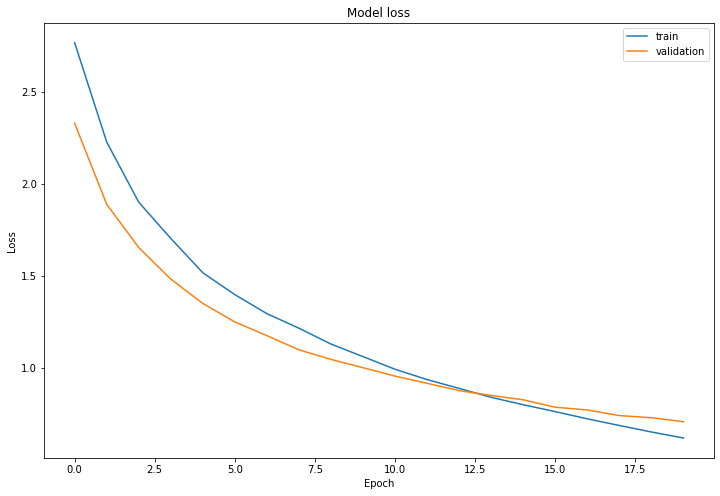

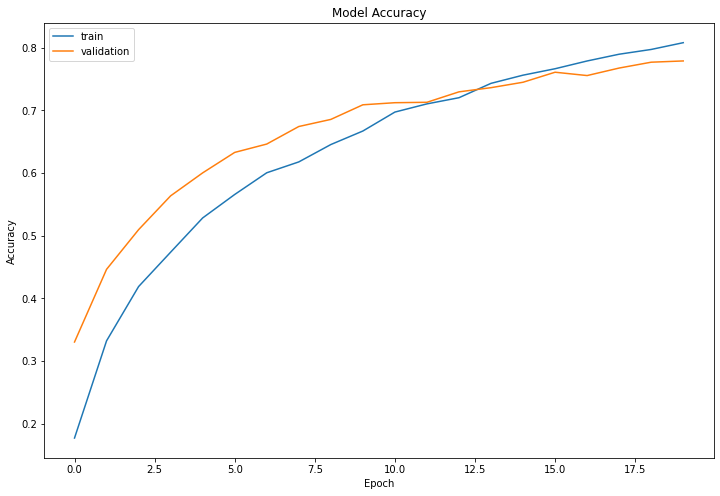

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
24/24 [==============================] - 1s 20ms/step - loss: 1.9145 - accuracy: 0.9521
test loss, test acc: [1.9144681692123413, 0.9521276354789734]


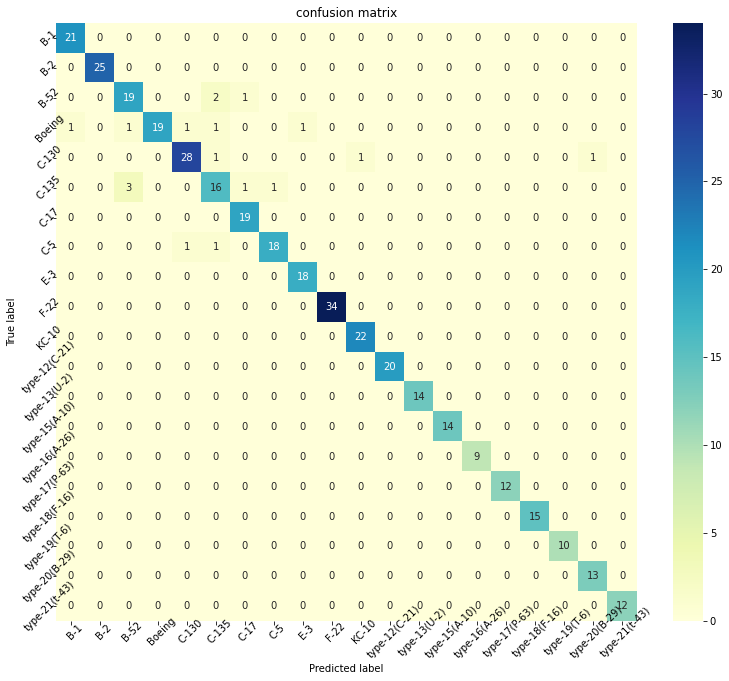

In [ ]:
## plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis =1), class_pred)

fig, ax = plt.subplots(figsize=(13, 11))

sns.heatmap(cm, annot=True,cmap='YlGnBu')

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
#Class wise accuracy
matrix = confusion_matrix(np.argmax(y_test, axis =1), class_pred)
class_acc = ((matrix.diagonal()/matrix.sum(axis=1)) *100)
print((matrix.diagonal()/matrix.sum(axis=1)) *100)

[100.         100.          86.36363636  79.16666667  90.32258065
  76.19047619 100.          90.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.        ]


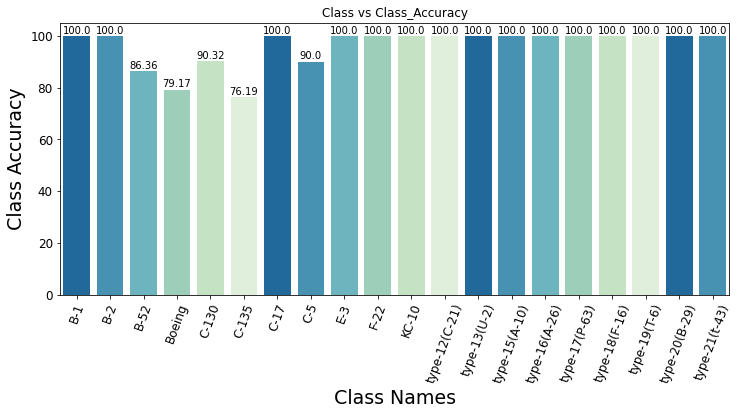

In [ ]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(12, 5))
pal = sns.color_palette("GnBu_r", n_colors=len(set(class_names_count_df["Class_Accuracy"])))

#Barplot with count
plots = sns.barplot(x="className", y="Class_Accuracy",data=class_names_count_df, palette=pal)
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.Class_Accuracy+1, s=row.Class_Accuracy, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=19)
  
# Setting the label for y-axis
plt.ylabel("Class Accuracy", size=19)
  
# Setting the title for the graph
plt.title("Class vs Class_Accuracy")
  
# Fianlly showing the plot
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=19)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

20/20 [==============================] - 2s 47ms/step - loss: 1.9145 - accuracy: 0.9521
Test Accuracy: 95.21%


In [ ]:
#Save model
model.save('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
print("model saved!!!")

model saved!!!
